# Training의 Debugger 결과 분석

이전 노트북에서 debugger 산출물이 있는 경우에만 이 노트북에서 Debugger 결과를 분석할 수 있습니다.

In [1]:
%store -r

In [2]:
print(training_job_debugger_artifacts_path)

s3://sagemaker-us-east-1-322537213286/tensorflow-training-2020-09-15-08-36-20-677/debug-output


## Tensors 분석

분석을 수행하기 전에 분석에 도움이 되는 Debugger의 개념을 아래 설명합니다.

* **Trial** - Tensor에 액세스 할 때 Debugger API의 핵심 요소이며, training job의 단일 실행을 나타내는 high-level 추상화 객체입니다. Training job에서 도출된 모든 Tensor와 연계됩니다.
* **Step** - 다음 추상화 수준의 객체이며, Debugger에서 step은 Training job의 단일 배치를 나타냅니다. 각 Trial은 여러 단계가 있으며, 각 Tensor는 여러 단계와 연계되고, 각 단계에서 특정 값을 가지게 됩니다.
* **Tensor** - Training job 동안 저장되는 실제 Tensor를 나타내는 객체이며, tensor는 1-D scalar도 가능합니다.(loss는 scalar로 저장됩니다.)

Debugger API에 대한 상세 내용은 [Amazon SageMaker Debugger github](https://github.com/awslabs/sagemaker-debugger)를 참조하십시오.

In [3]:
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(training_job_debugger_artifacts_path)

[2020-09-15 08:52:32.722 ip-172-16-71-232:12067 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-322537213286/tensorflow-training-2020-09-15-08-36-20-677/debug-output


In [4]:
for i in trial.tensor_names():
    print(i)

[2020-09-15 08:52:37.176 ip-172-16-71-232:12067 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-09-15 08:52:38.201 ip-172-16-71-232:12067 INFO trial.py:210] Loaded all steps
accuracy
batch
loss
size
val_accuracy
val_loss


In [5]:
import pandas as pd

def get_data(trial, tensor_name, batch_index, steps_range, mode):
    tensor = trial.tensor(tensor_name)
    vals = []
    for step_num in steps_range:
        val = tensor.value(step_num=step_num, mode=mode)[batch_index]
        vals.append(val)
    return pd.DataFrame(columns=['steps', tensor_name], data=list(zip(steps_range, vals)))

In [6]:
from smdebug import modes
import time

# Below we select the very first tensor from every batch.
# Feel free to modify this and select another tensor from the batch.
batch_index = 0

# This is a name of a tensor to analyze.
tensor_name = 'accuracy'

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print('Waiting for tensors to become available...')
    time.sleep(3)
print('\nDone')

print('Getting tensors...')
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()
    # show diff between lists
    steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
    
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=0, 
                    steps_range=steps_to_render, 
                    mode=modes.GLOBAL)
    print(data)
#     data.sort_values('steps', inplace=True)
#     data.plot(x='steps', y=tensor_name)
    
    rendered_steps.extend(steps_to_render)
    time.sleep(5)
    

Waiting for tensors to become available...

Done
Getting tensors...
     steps  accuracy
0        0  0.093750
1     2050  0.554688
2       10  0.545455
3     2060  0.552557
4       20  0.584821
..     ...       ...
440   2000  0.648438
441   2010  0.687500
442   2020  0.694568
443   2030  0.694556
444   2040  0.692454

[445 rows x 2 columns]


## Visualize Loss

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 299, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 399, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 499, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 599, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 699, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 799, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 899, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 999, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1099, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1199, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1299, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1399, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1499, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1599, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1699,

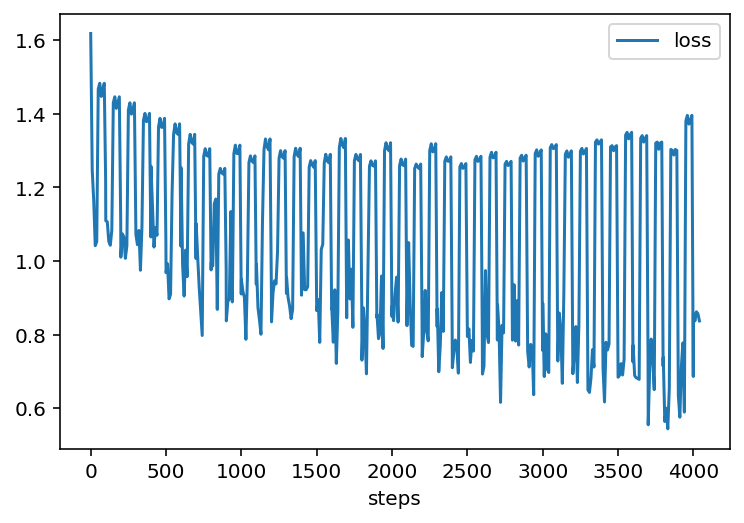

In [7]:
from smdebug import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

# Let's visualize weights of the first convolutional layer as they progressively change through training.
tensor_name = 'loss'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

## Visualize Accuracy

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 299, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 399, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 499, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 599, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 699, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 799, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 899, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 999, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1099, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1199, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1299, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1399, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1499, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1599, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1699,

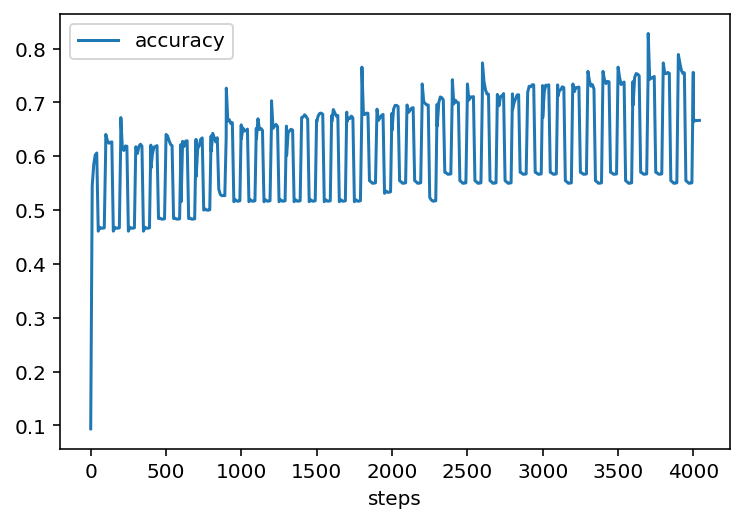

In [8]:
from smdebug import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

tensor_name = 'accuracy'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)